In [109]:
import numpy
import sklearn
import scipy
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import numpy as np
from scipy.optimize import minimize
import matplotlib
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import torch.utils.data as data_utils
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.preprocessing import StandardScaler
import torchvision
from torchvision.transforms import transforms
from sklearn.decomposition import PCA
from ERM import sklearn_optimize, error, adversarial_error
from helpers import ProblemType
from data_model import KFeaturesModel
import logging
logger = logging.getLogger()


%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Source

In [110]:
data_source = "fashion_mnist"
data_source = "cifar10"



In [111]:

if data_source == "cifar10":

    target_indices = [3,9]

    def unpickle(file):
        import pickle
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict


    test_data = unpickle("./data/cifar-10-batches-py/test_batch")[b"data"]
    test_labels = unpickle("./data/cifar-10-batches-py/test_batch")[b"labels"]

    # merge train data
    train_data_merged = []
    train_labels = []
    for i in range(1,6):
        data = unpickle("./data/cifar-10-batches-py/data_batch_"+str(i))
        train_data_merged.append(data[b'data'])
        train_labels += data[b'labels']
    train_data_merged = np.concatenate(train_data_merged)

    # get an index where the label is 1 or 9
    idx = np.where(np.array(train_labels) == target_indices[0])[0]
    idx = np.append(idx, np.where(np.array(train_labels) == target_indices[1])[0])
    train_data = train_data_merged[idx]
    train_labels = np.array(train_labels)[idx]

    # get an index where the label is 1 or 9
    idx = np.where(np.array(test_labels) == target_indices[0])[0]
    idx = np.append(idx, np.where(np.array(test_labels) == target_indices[1])[0])
    test_data = test_data[idx]
    test_labels = np.array(test_labels)[idx]

    # label the 9s as -1
    train_labels[train_labels == target_indices[1]] = -1
    test_labels[test_labels == target_indices[1]] = -1

    train_labels[train_labels == target_indices[0]] = 1
    test_labels[test_labels == target_indices[0]] = 1


In [112]:
if data_source == "fashion_mnist":

    mnist_train = datasets.FashionMNIST("./data", train=True, download=True, transform=transforms.ToTensor())
    mnist_test = datasets.FashionMNIST("./data", train=False, download=True, transform=transforms.ToTensor())

    train_idx = (mnist_train.targets % 2 == 0)
    test_idx = (mnist_test.targets % 2 == 0)

    mnist_train.targets[train_idx] = 1
    mnist_train.targets[~train_idx] = -1

    mnist_test.targets[test_idx] = 1
    mnist_test.targets[~test_idx] = -1

    # let's flatten the images
    train_data = train_data.reshape(-1, 28*28)
    test_data = test_data.reshape(-1, 28*28)

    # display some stats about the data
    print("Train data shape: ", train_data.shape)
    print("Test data shape: ", test_data.shape)
    print("Train labels shape: ", train_labels.shape)
    print("Test labels shape: ", test_labels.shape)

    # display some random images from both classes including a label for each image
    fig, ax = plt.subplots(2, 5)
    fig.suptitle("Random images from the dataset")
    for i in range(2):
        for j in range(5):
            idx = np.random.randint(0, train_data.shape[0])
            ax[i, j].imshow(train_data[idx].reshape(28, 28), cmap="gray")
            ax[i, j].set_title(train_labels[idx])
            ax[i, j].axis("off")    
    plt.show()

## Preprocessing

In [113]:
# make sure data is in numpy
if not isinstance(train_data, np.ndarray):
    train_data = train_data.numpy()
if not isinstance(test_data, np.ndarray):
    test_data = test_data.numpy()
if not isinstance(train_labels, np.ndarray):
    train_labels = train_labels.numpy()
if not isinstance(test_labels, np.ndarray):
    test_labels = test_labels.numpy()

In [114]:
X_train = train_data
y_train = train_labels
X_test = test_data
y_test = test_labels

# PCA

In [115]:
mnist_components = 500
cifar_components = 2500
components = mnist_components if data_source == "fashion_mnist" else cifar_components

In [116]:
pca = PCA(n_components=components) # n_components = 50
pca.fit(X_train)

PCA(n_components=2500)

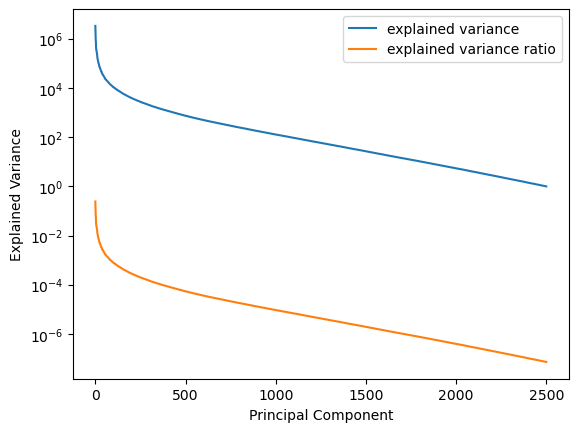

In [117]:
# plot the explained_variance_
# plt.figure(figsize=(10, 10))
plt.plot(pca.explained_variance_, label="explained variance")
plt.plot(pca.explained_variance_ratio_, label="explained variance ratio")
# plt.plot(np.cumsum(pca.explained_variance_ratio_), label="cumulative explained variance ratio")
plt.legend()
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance")
plt.yscale("log")
# plt.xscale("log")
plt.show()

In [118]:
# for both the train and test set, transform the data using the PCA
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [119]:

# obtain the dimension of the features
d = X_train.shape[1]
# sample a blank weight vector
w = np.ones(d)

# create a y vector
y_train
lam = 0.01
epsilon = 0

problem_type = ProblemType.Logistic


In [120]:

sigma_delta_content = np.ones(d)
sigma_delta = np.diag(sigma_delta_content)

weights, _ = sklearn_optimize(w, X_train, y_train, lam, epsilon, problem_type,sigma_delta=sigma_delta)


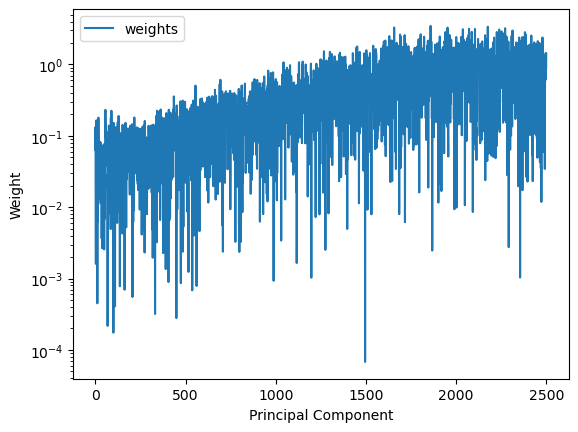

In [121]:
# plot the norm of each component of the weight vector
plt.plot(np.abs(weights), label="weights")
# plt.plot(np.abs(weights_direct), label="weights_direct")
# plt.plot(np.abs(weights_inv), label="weights_inv")
plt.xlabel("Principal Component")
plt.ylabel("Weight")
plt.yscale("log")
plt.legend()
plt.show()

(2500,)


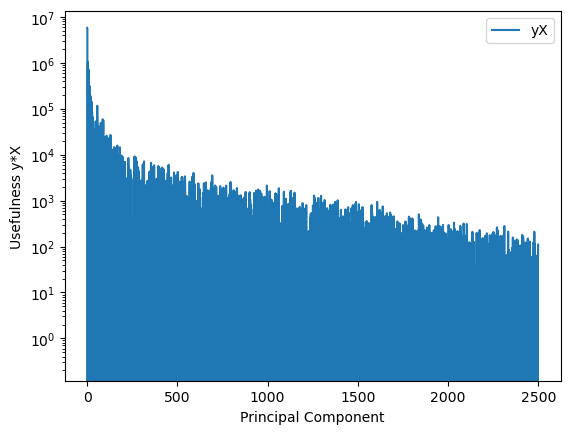

In [122]:

# compute y*X and sum over the data
yX = np.sum(y_train[:, np.newaxis] * X_train, axis=0)
print(yX.shape)
# compute elementwise yX * weights
yXw = yX
# plot yXw
plt.plot(yXw, label="yX")
plt.xlabel("Principal Component")
plt.ylabel("Usefulness y*X")
plt.yscale("log")
plt.legend()
plt.show()

(2500,)


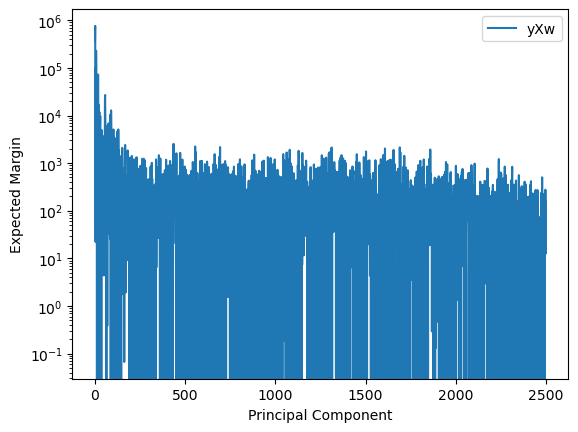

In [123]:

# compute y*X and sum over the data
yX = np.sum(y_train[:, np.newaxis] * X_train, axis=0)
print(yX.shape)
# compute elementwise yX * weights
yXw = yX * weights
# yXw_direct = yX * weights_direct
# yXw_inv = yX * weights_inv
# plot yXw
plt.plot(yXw, label="yXw")
# plt.plot(yXw_direct, label="yXw_direct")
# plt.plot(yXw_inv, label="yXw_inv")
plt.xlabel("Principal Component")
plt.ylabel("Expected Margin")
plt.yscale("log")
plt.legend()
plt.show()


In [124]:
attack_epsilon = 1
sigma_upsilon_trace = np.ones(d)
sigma_upsilon = np.diag(1/sigma_upsilon_trace)

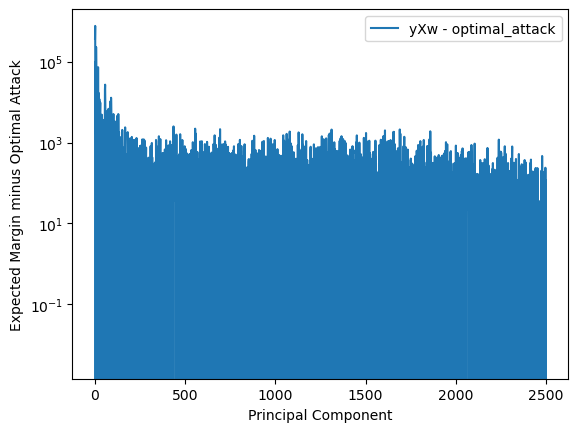

In [125]:
# compute w*sigma_upsilon*w / np.sqrt(w*w)
nww = np.sqrt(weights.dot(weights))
wSw = weights.dot(sigma_upsilon).dot(weights)
optimal_attack = attack_epsilon * np.sqrt(wSw)
# plot yXw - optimal_attack
plt.plot(yXw - optimal_attack, label="yXw - optimal_attack")
# plt.plot(yXw_direct - optimal_attack, label="yXw_direct - optimal_attack")
# plt.plot(yXw_inv - optimal_attack, label="yXw_inv - optimal_attack")
plt.xlabel("Principal Component")
plt.ylabel("Expected Margin minus Optimal Attack")
plt.yscale("log")
plt.legend()
plt.show()



In [126]:
robustness_mask = (yXw - optimal_attack) > 2*1e3
robustness_mask.shape
# count the number of robust features
np.sum(robustness_mask)

63

## attacking all the features

In [127]:


sigma_upsilon_trace = np.ones(d)
print(sigma_upsilon_trace[0],sigma_upsilon_trace[-1])
sigma_upsilon = np.diag(sigma_upsilon_trace)

def get_errors(w):

    # compute y pred train
    y_pred_train = np.sign(np.dot(X_train, w))
    # compute y pred test
    y_pred_test = np.sign(np.dot(X_test, w))
    # evaluate error and adversarial error, format as percentages to 4 decimal places
    print(f"Training error: {error(y_pred_train, y_train):.8f}")
    print(f"Test error: {error(y_pred_test, y_test):.8f}")
    print(f"Adversarial error: {adversarial_error(y_test, X_test, w, attack_epsilon, sigma_upsilon):.8f}")


print("Training with SigmaDelta = Identity:")
get_errors(weights)
# print("\nTraining with Diag(SigmaDelta) = Explained Variance")
# get_errors(weights_direct)
# print("\nTraining with Diag(SigmaDelta) = 1 / Explained Variance")
# get_errors(weights_inv)

1.0 1.0
Training with SigmaDelta = Identity:
Training error: 0.07490000
Test error: 0.22250000
Adversarial error: 0.26450000


## attacking the non-robust features

In [128]:


sigma_upsilon_trace = np.ones(d)
# only attack those features that are non-robust
sigma_upsilon_trace[robustness_mask] = 0.0
sigma_upsilon = np.diag(sigma_upsilon_trace)

def get_errors(w):

    # compute y pred train
    y_pred_train = np.sign(np.dot(X_train, w))
    # compute y pred test
    y_pred_test = np.sign(np.dot(X_test, w))
    # evaluate error and adversarial error, format as percentages to 4 decimal places
    print(f"Training error: {error(y_pred_train, y_train):.8f}")
    print(f"Test error: {error(y_pred_test, y_test):.8f}")
    print(f"Adversarial error: {adversarial_error(y_test, X_test, w, attack_epsilon, sigma_upsilon):.8f}")


print("Training with SigmaDelta = Identity:")
get_errors(weights)
# print("\nTraining with Diag(SigmaDelta) = Explained Variance")
# get_errors(weights_direct)
# print("\nTraining with Diag(SigmaDelta) = 1 / Explained Variance")
# get_errors(weights_inv)

Training with SigmaDelta = Identity:
Training error: 0.07490000
Test error: 0.22250000
Adversarial error: 0.26450000


## attacking the robust-features

In [129]:
sigma_upsilon_trace = np.ones(d)
# only attack those features that are non-robust
sigma_upsilon_trace[~robustness_mask] = 0.0
sigma_upsilon = np.diag(sigma_upsilon_trace)

def get_errors(w):

    # compute y pred train
    y_pred_train = np.sign(np.dot(X_train, w))
    # compute y pred test
    y_pred_test = np.sign(np.dot(X_test, w))
    # evaluate error and adversarial error, format as percentages to 4 decimal places
    print(f"Training error: {error(y_pred_train, y_train):.8f}")
    print(f"Test error: {error(y_pred_test, y_test):.8f}")
    print(f"Adversarial error: {adversarial_error(y_test, X_test, w, attack_epsilon, sigma_upsilon):.8f}")


print("Training with SigmaDelta = Identity:")
get_errors(weights)
# print("\nTraining with Diag(SigmaDelta) = Explained Variance")
# get_errors(weights_direct)
# print("\nTraining with Diag(SigmaDelta) = 1 / Explained Variance")
# get_errors(weights_inv)

Training with SigmaDelta = Identity:
Training error: 0.07490000
Test error: 0.22250000
Adversarial error: 0.22300000


# Now let us defend the non-robust features

In [130]:
epsilon = 1


sigma_delta_content = np.ones(d)
sigma_delta_content[robustness_mask] = 0.0
sigma_delta = np.diag(sigma_delta_content)

weights, _ = sklearn_optimize(w, X_train, y_train, lam, epsilon, problem_type,sigma_delta=sigma_delta)

sigma_delta_content = np.ones(d)
sigma_delta_content[~robustness_mask] = 0.0
sigma_delta = np.diag(sigma_delta_content)

weights_robust, _ = sklearn_optimize(w, X_train, y_train, lam, epsilon, problem_type,sigma_delta=sigma_delta)

sigma_delta = np.diag(np.ones(d))

weights_identity, _ = sklearn_optimize(w, X_train, y_train, lam, epsilon, problem_type,sigma_delta=sigma_delta)

sigma_delta_content = pca.explained_variance_
# sigma_delta_content = pca.explained_variance_ratio_
# sigma_delta_content = pca.singular_values_
# normalise by dividing by the sum and multiplying by d
# sigma_delta_content[robustness_mask] = 0.0
sigma_delta_content = sigma_delta_content / np.sum(sigma_delta_content) * d
sigma_delta = np.diag(sigma_delta_content)
weights_direct, _ = sklearn_optimize(w, X_train, y_train, lam, epsilon, problem_type,sigma_delta=sigma_delta)

sigma_delta_content = 1/pca.explained_variance_
# sigma_delta_content = 1/pca.explained_variance_ratio_
# sigma_delta_content = 1/pca.singular_values_
# normalise by dividing by the sum and multiplying by d
# sigma_delta_content[robustness_mask] = 0.0
sigma_delta_content = sigma_delta_content / np.sum(sigma_delta_content) * d
sigma_delta = np.diag(sigma_delta_content)
weights_inv, _ = sklearn_optimize(w, X_train, y_train, lam, epsilon, problem_type,sigma_delta=sigma_delta)

In [131]:
attack_epsilon = 1

sigma_upsilon_trace = np.ones(d)
sigma_upsilon = np.diag(sigma_upsilon_trace)

def get_errors(w):

    # compute y pred train
    y_pred_train = np.sign(np.dot(X_train, w))
    # compute y pred test
    y_pred_test = np.sign(np.dot(X_test, w))
    # evaluate error and adversarial error, format as percentages to 4 decimal places
    print(f"Training error: {error(y_pred_train, y_train):.8f}")
    print(f"Test error: {error(y_pred_test, y_test):.8f}")
    print(f"Adversarial error: {adversarial_error(y_test, X_test, w, attack_epsilon, sigma_upsilon):.8f}")

print("Training with SigmaDelta = Identity: on non-robust features")
get_errors(weights)
print("\nTraining with SigmaDelta = Identity: on robust features")
get_errors(weights_robust)
print("\nTraining with SigmaDelta = Identity:")
get_errors(weights_identity)
print("\nTraining with Diag(SigmaDelta) = Explained Variance")
get_errors(weights_direct)
print("\nTraining with Diag(SigmaDelta) = 1 / Explained Variance")
get_errors(weights_inv)

Training with SigmaDelta = Identity: on non-robust features
Training error: 0.07930000
Test error: 0.19650000
Adversarial error: 0.23050000
Training with SigmaDelta = Identity: on robust features
Training error: 0.07400000
Test error: 0.21950000
Adversarial error: 0.26400000
Training with SigmaDelta = Identity:
Training error: 0.08020000
Test error: 0.19500000
Adversarial error: 0.22550000

Training with Diag(SigmaDelta) = Explained Variance
Training error: 0.07360000
Test error: 0.22100000
Adversarial error: 0.26250000

Training with Diag(SigmaDelta) = 1 / Explained Variance
Training error: 0.08730000
Test error: 0.19650000
Adversarial error: 0.22300000


# Repeat the same on the full FashionMnist dataset


In [176]:
data_source = "fashion_mnist"

Train data shape:  torch.Size([60000, 784])
Test data shape:  torch.Size([10000, 784])
Train labels shape:  torch.Size([60000])
Test labels shape:  torch.Size([10000])


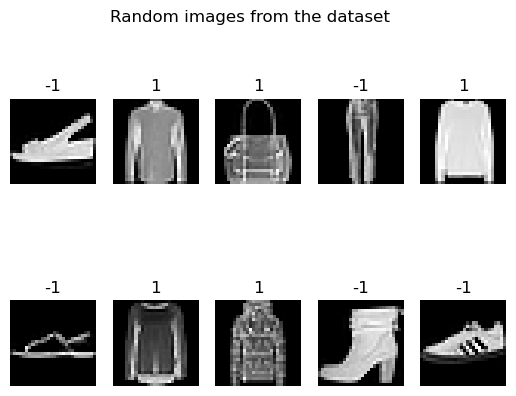

In [177]:
if data_source == "fashion_mnist":

    mnist_train = datasets.FashionMNIST("./data", train=True, download=True, transform=transforms.ToTensor())
    mnist_test = datasets.FashionMNIST("./data", train=False, download=True, transform=transforms.ToTensor())

    train_idx = (mnist_train.targets % 2 == 0)
    test_idx = (mnist_test.targets % 2 == 0)

    mnist_train.targets[train_idx] = 1
    mnist_train.targets[~train_idx] = -1

    mnist_test.targets[test_idx] = 1
    mnist_test.targets[~test_idx] = -1

    # let's flatten the images
    train_data = mnist_train.data.reshape(-1, 28*28)
    test_data = mnist_test.data.reshape(-1, 28*28)

    train_labels = mnist_train.targets
    test_labels = mnist_test.targets

    # display some stats about the data
    print("Train data shape: ", train_data.shape)
    print("Test data shape: ", test_data.shape)
    print("Train labels shape: ", train_labels.shape)
    print("Test labels shape: ", test_labels.shape)

    # convert all to numpy
    train_data = train_data.numpy()
    test_data = test_data.numpy()
    train_labels = train_labels.numpy()
    test_labels = test_labels.numpy()

    # display some random images from both classes including a label for each image
    fig, ax = plt.subplots(2, 5)
    fig.suptitle("Random images from the dataset")
    for i in range(2):
        for j in range(5):
            idx = np.random.randint(0, train_data.shape[0])
            ax[i, j].imshow(train_data[idx].reshape(28, 28), cmap="gray")
            ax[i, j].set_title(train_labels[idx])
            ax[i, j].axis("off")    
    plt.show()

In [178]:
X_train = train_data
y_train = train_labels
X_test = test_data
y_test = test_labels

In [179]:
mnist_components = 500
cifar_components = 2500
components = mnist_components if data_source == "fashion_mnist" else cifar_components

In [180]:
pca = PCA(n_components=components) # n_components = 50
pca.fit(X_train)

PCA(n_components=500)

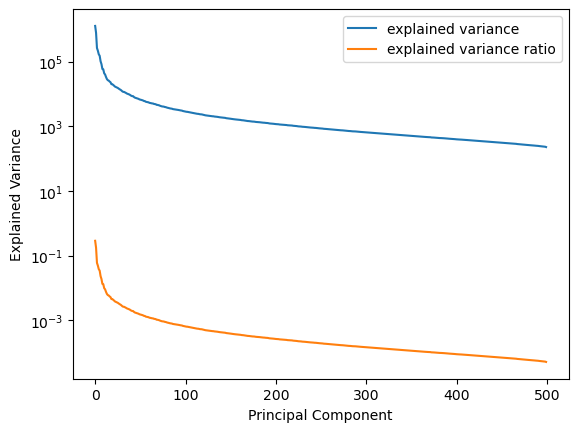

In [181]:
# plot the explained_variance_
# plt.figure(figsize=(10, 10))
plt.plot(pca.explained_variance_, label="explained variance")
plt.plot(pca.explained_variance_ratio_, label="explained variance ratio")
# plt.plot(np.cumsum(pca.explained_variance_ratio_), label="cumulative explained variance ratio")
plt.legend()
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance")
plt.yscale("log")
# plt.xscale("log")
plt.show()

In [182]:
# project the data
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [183]:

# obtain the dimension of the features
d = X_train.shape[1]
# sample a blank weight vector
w = np.ones(d)

# create a y vector
y_train
lam = 0.01
epsilon = 0

problem_type = ProblemType.Logistic


In [184]:

sigma_delta_content = np.ones(d)
sigma_delta = np.diag(sigma_delta_content)

weights, _ = sklearn_optimize(w, X_train, y_train, lam, epsilon, problem_type,sigma_delta=sigma_delta)



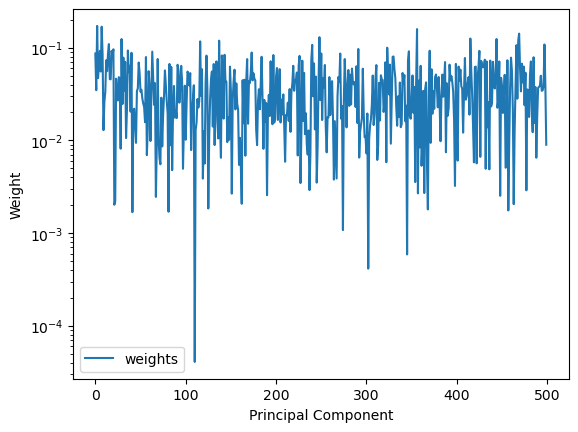

In [185]:
# plot the norm of each component of the weight vector
plt.plot(np.abs(weights), label="weights")
# plt.plot(np.abs(weights_direct), label="weights_direct")
# plt.plot(np.abs(weights_inv), label="weights_inv")
plt.xlabel("Principal Component")
plt.ylabel("Weight")
plt.yscale("log")
plt.legend()
plt.show()

(500,)


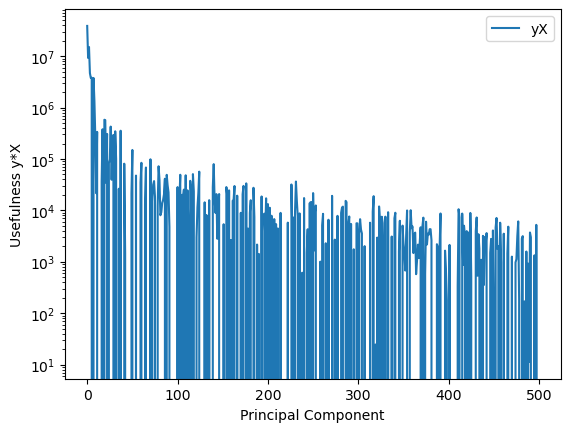

In [186]:

# compute y*X and sum over the data
yX = np.sum(y_train[:, np.newaxis] * X_train, axis=0)
print(yX.shape)
# compute elementwise yX * weights
yXw = yX
# plot yXw
plt.plot(yXw, label="yX")
plt.xlabel("Principal Component")
plt.ylabel("Usefulness y*X")
plt.yscale("log")
plt.legend()
plt.show()

(500,)


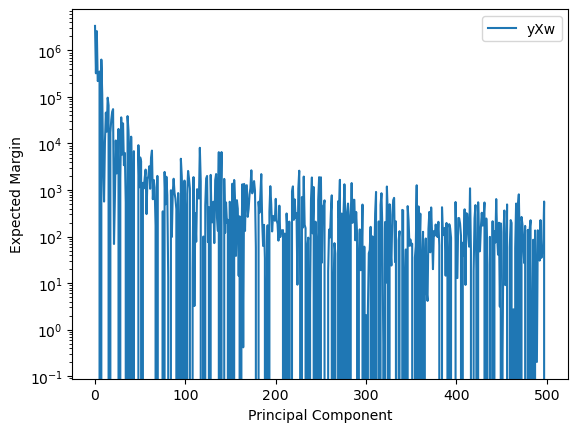

In [187]:

# compute y*X and sum over the data
yX = np.sum(y_train[:, np.newaxis] * X_train, axis=0)
print(yX.shape)
# compute elementwise yX * weights
yXw = yX * weights
# yXw_direct = yX * weights_direct
# yXw_inv = yX * weights_inv
# plot yXw
plt.plot(yXw, label="yXw")
# plt.plot(yXw_direct, label="yXw_direct")
# plt.plot(yXw_inv, label="yXw_inv")
plt.xlabel("Principal Component")
plt.ylabel("Expected Margin")
plt.yscale("log")
plt.legend()
plt.show()


In [188]:
attack_epsilon = 20
sigma_upsilon_trace = np.ones(d)
sigma_upsilon = np.diag(sigma_upsilon_trace)

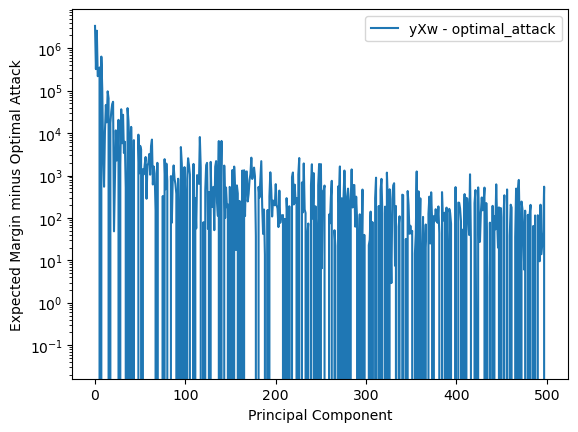

In [189]:
# compute w*sigma_upsilon*w / np.sqrt(w*w)
nww = np.sqrt(weights.dot(weights))
wSw = weights.dot(sigma_upsilon).dot(weights)
optimal_attack = attack_epsilon * np.sqrt(wSw)
# plot yXw - optimal_attack
plt.plot(yXw - optimal_attack, label="yXw - optimal_attack")
# plt.plot(yXw_direct - optimal_attack, label="yXw_direct - optimal_attack")
# plt.plot(yXw_inv - optimal_attack, label="yXw_inv - optimal_attack")
plt.xlabel("Principal Component")
plt.ylabel("Expected Margin minus Optimal Attack")
plt.yscale("log")
plt.legend()
plt.show()



In [210]:
robustness_mask = (yXw - optimal_attack) > 2*1e4
robustness_mask.shape
# count the number of robust features
np.sum(robustness_mask)

18

## Attacking all the features

In [211]:


sigma_upsilon_trace = np.ones(d)
print(sigma_upsilon_trace[0],sigma_upsilon_trace[-1])
sigma_upsilon = np.diag(sigma_upsilon_trace)

def get_errors(w):

    # compute y pred train
    y_pred_train = np.sign(np.dot(X_train, w))
    # compute y pred test
    y_pred_test = np.sign(np.dot(X_test, w))
    # evaluate error and adversarial error, format as percentages to 4 decimal places
    print(f"Training error: {error(y_pred_train, y_train):.8f}")
    print(f"Test error: {error(y_pred_test, y_test):.8f}")
    print(f"Adversarial error: {adversarial_error(y_test, X_test, w, attack_epsilon, sigma_upsilon):.8f}")


print("Training with SigmaDelta = Identity:")
get_errors(weights)
# print("\nTraining with Diag(SigmaDelta) = Explained Variance")
# get_errors(weights_direct)
# print("\nTraining with Diag(SigmaDelta) = 1 / Explained Variance")
# get_errors(weights_inv)

1.0 1.0
Training with SigmaDelta = Identity:
Training error: 0.03255000
Test error: 0.03960000
Adversarial error: 0.06350000


## Attacking the non-robust features

In [212]:
sigma_upsilon_trace = np.ones(d)
# only attack those features that are non-robust
sigma_upsilon_trace[robustness_mask] = 0.0
sigma_upsilon = np.diag(sigma_upsilon_trace)

def get_errors(w):

    # compute y pred train
    y_pred_train = np.sign(np.dot(X_train, w))
    # compute y pred test
    y_pred_test = np.sign(np.dot(X_test, w))
    # evaluate error and adversarial error, format as percentages to 4 decimal places
    print(f"Training error: {error(y_pred_train, y_train):.8f}")
    print(f"Test error: {error(y_pred_test, y_test):.8f}")
    print(f"Adversarial error: {adversarial_error(y_test, X_test, w, attack_epsilon, sigma_upsilon):.8f}")


print("Training with SigmaDelta = Identity:")
get_errors(weights)
# print("\nTraining with Diag(SigmaDelta) = Explained Variance")
# get_errors(weights_direct)
# print("\nTraining with Diag(SigmaDelta) = 1 / Explained Variance")
# get_errors(weights_inv)

Training with SigmaDelta = Identity:
Training error: 0.03255000
Test error: 0.03960000
Adversarial error: 0.05950000


## Attacking the robust-features

In [213]:
sigma_upsilon_trace = np.ones(d)
# only attack those features that are non-robust
sigma_upsilon_trace[~robustness_mask] = 0.0
sigma_upsilon = np.diag(sigma_upsilon_trace)

def get_errors(w):

    # compute y pred train
    y_pred_train = np.sign(np.dot(X_train, w))
    # compute y pred test
    y_pred_test = np.sign(np.dot(X_test, w))
    # evaluate error and adversarial error, format as percentages to 4 decimal places
    print(f"Training error: {error(y_pred_train, y_train):.8f}")
    print(f"Test error: {error(y_pred_test, y_test):.8f}")
    print(f"Adversarial error: {adversarial_error(y_test, X_test, w, attack_epsilon, sigma_upsilon):.8f}")


print("Training with SigmaDelta = Identity:")
get_errors(weights)
# print("\nTraining with Diag(SigmaDelta) = Explained Variance")
# get_errors(weights_direct)
# print("\nTraining with Diag(SigmaDelta) = 1 / Explained Variance")
# get_errors(weights_inv)

Training with SigmaDelta = Identity:
Training error: 0.03255000
Test error: 0.03960000
Adversarial error: 0.04270000


## Defend the non-robust features

In [214]:
epsilon = 20

sigma_delta_content = np.ones(d)
sigma_delta_content[robustness_mask] = 0.0
sigma_delta = np.diag(sigma_delta_content)

weights, _ = sklearn_optimize(w, X_train, y_train, lam, epsilon, problem_type,sigma_delta=sigma_delta)

sigma_delta_content = np.ones(d)
sigma_delta_content[~robustness_mask] = 0.0
sigma_delta = np.diag(sigma_delta_content)

weights_robust, _ = sklearn_optimize(w, X_train, y_train, lam, epsilon, problem_type,sigma_delta=sigma_delta)

sigma_delta = np.diag(np.ones(d))

weights_identity, _ = sklearn_optimize(w, X_train, y_train, lam, epsilon, problem_type,sigma_delta=sigma_delta)

sigma_delta_content = pca.explained_variance_
# sigma_delta_content = pca.explained_variance_ratio_
# sigma_delta_content = pca.singular_values_
# normalise by dividing by the sum and multiplying by d
# sigma_delta_content[robustness_mask] = 0.0
sigma_delta_content = sigma_delta_content / np.sum(sigma_delta_content) * d
sigma_delta = np.diag(sigma_delta_content)
weights_direct, _ = sklearn_optimize(w, X_train, y_train, lam, epsilon, problem_type,sigma_delta=sigma_delta)

sigma_delta_content = 1/pca.explained_variance_
# sigma_delta_content = 1/pca.explained_variance_ratio_
# sigma_delta_content = 1/pca.singular_values_
# normalise by dividing by the sum and multiplying by d
# sigma_delta_content[robustness_mask] = 0.0
sigma_delta_content = sigma_delta_content / np.sum(sigma_delta_content) * d
sigma_delta = np.diag(sigma_delta_content)
weights_inv, _ = sklearn_optimize(w, X_train, y_train, lam, epsilon, problem_type,sigma_delta=sigma_delta)

In [215]:
attack_epsilon = 20

sigma_upsilon_trace = np.ones(d)
sigma_upsilon = np.diag(sigma_upsilon_trace)

def get_errors(w):

    # compute y pred train
    y_pred_train = np.sign(np.dot(X_train, w))
    # compute y pred test
    y_pred_test = np.sign(np.dot(X_test, w))
    # evaluate error and adversarial error, format as percentages to 4 decimal places
    print(f"Training error: {error(y_pred_train, y_train):.8f}")
    print(f"Test error: {error(y_pred_test, y_test):.8f}")
    print(f"Adversarial error: {adversarial_error(y_test, X_test, w, attack_epsilon, sigma_upsilon):.8f}")

print("Training with SigmaDelta = Identity: on non-robust features")
get_errors(weights)
print("Training with SigmaDelta = Identity: on robust features")
get_errors(weights_robust)
print("Training with SigmaDelta = Identity:")
get_errors(weights_identity)
print("\nTraining with Diag(SigmaDelta) = Explained Variance")
get_errors(weights_direct)
print("\nTraining with Diag(SigmaDelta) = 1 / Explained Variance")
get_errors(weights_inv)

Training with SigmaDelta = Identity: on non-robust features
Training error: 0.03641667
Test error: 0.03990000
Adversarial error: 0.04950000
Training with SigmaDelta = Identity: on robust features
Training error: 0.03256667
Test error: 0.03840000
Adversarial error: 0.06070000
Training with SigmaDelta = Identity:
Training error: 0.03523333
Test error: 0.03950000
Adversarial error: 0.04930000

Training with Diag(SigmaDelta) = Explained Variance
Training error: 0.03368333
Test error: 0.03910000
Adversarial error: 0.05580000

Training with Diag(SigmaDelta) = 1 / Explained Variance
Training error: 0.03538333
Test error: 0.03920000
Adversarial error: 0.05030000
